# AIM

DQN  
CartPole-v0  
PyTorch

# REFERENCE

* [https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)

In [209]:
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
from gym import wrappers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [210]:
from pkg_resources import get_distribution
import platform
print("python", platform.python_version())
print("")
libs = ["numpy", "matplotlib", "gym", "torch", "torchvision"]
for lib in libs:
    version = get_distribution(lib).version
    print(lib, version)

python 3.5.2

numpy 1.13.1
matplotlib 2.0.2
gym 0.9.2
torch 0.2.0.post3
torchvision 0.1.9


In [211]:
env = gym.make("CartPole-v0")
print("observation space num: ", env.observation_space.shape[0])
print("action space num: ", env.action_space.n)

pobs = env.reset()
done = False
while not done:
    act = env.action_space.sample()
    obs, reward, done, _ = env.step(act)
    print(pobs, act, reward, obs, done)
    pobs = obs

[2017-09-17 18:18:08,327] Making new env: CartPole-v0


observation space num:  4
action space num:  2
[ 0.01699081 -0.00854465 -0.03683945  0.00082669] 1 1.0 [ 0.01681992  0.18708574 -0.03682292 -0.30324814] False
[ 0.01681992  0.18708574 -0.03682292 -0.30324814] 0 1.0 [ 0.02056164 -0.0074926  -0.04288788 -0.02240197] False
[ 0.02056164 -0.0074926  -0.04288788 -0.02240197] 1 1.0 [ 0.02041178  0.18821733 -0.04333592 -0.32830209] False
[ 0.02041178  0.18821733 -0.04333592 -0.32830209] 1 1.0 [ 0.02417613  0.38392857 -0.04990196 -0.63433011] False
[ 0.02417613  0.38392857 -0.04990196 -0.63433011] 0 1.0 [ 0.0318547   0.18953691 -0.06258857 -0.35777069] False
[ 0.0318547   0.18953691 -0.06258857 -0.35777069] 0 1.0 [ 0.03564544 -0.004642   -0.06974398 -0.08546166] False
[ 0.03564544 -0.004642   -0.06974398 -0.08546166] 0 1.0 [ 0.0355526  -0.1986985  -0.07145321  0.18442731] False
[ 0.0355526  -0.1986985  -0.07145321  0.18442731] 0 1.0 [ 0.03157863 -0.3927292  -0.06776467  0.45374133] False
[ 0.03157863 -0.3927292  -0.06776467  0.45374133] 1 1.0 [

[2017-09-18 11:53:45,716] Making new env: CartPole-v0


Train
epoch	EPSILON	reward	total_step	elapsed_time
1000	0.0999999999999992	80.352	82352	134.91835618019104[sec]
2000	0.0999999999999992	148.985	233337	257.46157598495483[sec]
3000	0.0999999999999992	147.917	383254	259.0071289539337[sec]


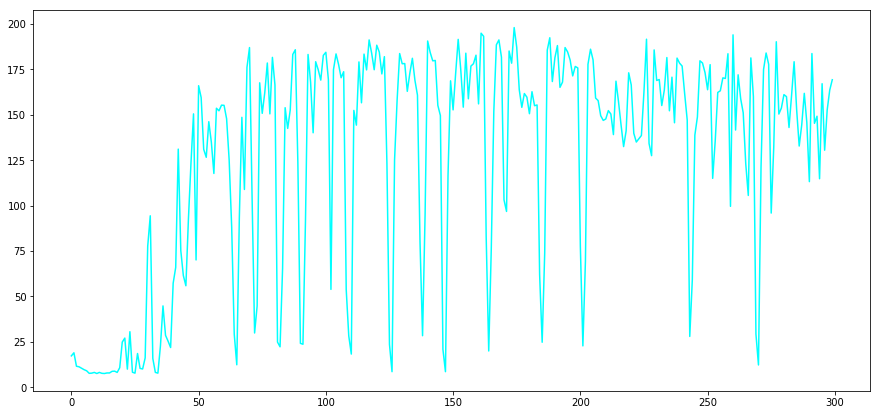

In [221]:
# 環境
MONITOR = False
env = gym.make("CartPole-v0")
if MONITOR:
    env = wrappers.Monitor(env, "./tmp", force=True)

obs_num = env.observation_space.shape[0]
acts_num = env.action_space.n
HIDDEN_SIZE = 100

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(obs_num, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc4 = nn.Linear(HIDDEN_SIZE, acts_num)
    
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        y = F.relu(self.fc4(h))
        return y

# 定数
EPOCH_NUM = 3000 # エポック数
STEP_MAX = 200 # 最高ステップ数
MEMORY_SIZE = 200 # メモリサイズいくつで学習を開始するか
BATCH_SIZE = 50 # バッチサイズ
EPSILON = 1.0 # ε-greedy法
EPSILON_DECREASE = 0.001 # εの減少値
EPSILON_MIN = 0.1 # εの下限
START_REDUCE_EPSILON = 200 # εを減少させるステップ数
TRAIN_FREQ = 10 # Q関数の学習間隔
UPDATE_TARGET_Q_FREQ = 20 # Q関数の更新間隔
GAMMA = 0.97 # 割引率
LOG_FREQ = 1000 # ログ出力の間隔

# モデル
Q = NN() # 近似Q関数
Q_ast = copy.deepcopy(Q)
optimizer = optim.RMSprop(Q.parameters(), lr=0.00015, alpha=0.95, eps=0.01)

total_step = 0 # 総ステップ（行動）数
memory = [] # メモリ
total_rewards = [] # 累積報酬記録用リスト

# 学習開始
print("Train")
print("\t".join(["epoch", "EPSILON", "reward", "total_step", "elapsed_time"]))
start = time.time()
for epoch in range(EPOCH_NUM):
    pobs = env.reset() # 環境初期化
    step = 0 # ステップ数
    done = False # ゲーム終了フラグ
    total_reward = 0 # 累積報酬
    while not done and step < STEP_MAX:
        if MONITOR:
            env.render()
        # 行動選択
        pact = env.action_space.sample()
        # ε-greedy法
        if np.random.rand() > EPSILON:
            # 最適な行動を予測
            pobs_ = np.array(pobs, dtype="float32").reshape((1, obs_num))
            pobs_ = Variable(torch.from_numpy(pobs_))
            pact = Q(pobs_)
            maxs, indices = torch.max(pact.data, 1)
            pact = indices.numpy()[0]
        # 行動
        obs, reward, done, _ = env.step(pact)
        if done:
            reward = -1
        # メモリに蓄積
        memory.append((pobs, pact, reward, obs, done)) # 状態、行動、報酬、行動後の状態、ゲーム終了フラグ
        if len(memory) > MEMORY_SIZE: # メモリサイズを超えていれば消していく
            memory.pop(0)
        # 学習
        if len(memory) == MEMORY_SIZE: # メモリサイズ分溜まっていれば学習
            # 経験リプレイ
            if total_step % TRAIN_FREQ == 0:
                memory_ = np.random.permutation(memory)
                memory_idx = range(len(memory_))
                for i in memory_idx[::BATCH_SIZE]:
                    batch = np.array(memory_[i:i+BATCH_SIZE]) # 経験ミニバッチ
                    pobss = np.array(batch[:,0].tolist(), dtype="float32").reshape((BATCH_SIZE, obs_num))
                    pacts = np.array(batch[:,1].tolist(), dtype="int32")
                    rewards = np.array(batch[:,2].tolist(), dtype="int32")
                    obss = np.array(batch[:,3].tolist(), dtype="float32").reshape((BATCH_SIZE, obs_num))
                    dones = np.array(batch[:,4].tolist(), dtype="bool")
                    # set y
                    pobss_ = Variable(torch.from_numpy(pobss))
                    q = Q(pobss_)
                    obss_ = Variable(torch.from_numpy(obss))
                    maxs, indices = torch.max(Q_ast(obss_).data, 1)
                    maxq = maxs.numpy() # maxQ
                    target = copy.deepcopy(q.data.numpy())
                    for j in range(BATCH_SIZE):
                        target[j, pacts[j]] = rewards[j]+GAMMA*maxq[j]*(not dones[j]) # 教師信号
                    # Perform a gradient descent step
                    optimizer.zero_grad()
                    loss = nn.MSELoss()(q, Variable(torch.from_numpy(target)))
                    loss.backward()
                    optimizer.step()
            # Q関数の更新
            if total_step % UPDATE_TARGET_Q_FREQ == 0:
                Q_ast = copy.deepcopy(Q)
        # εの減少
        if EPSILON > EPSILON_MIN and total_step > START_REDUCE_EPSILON:
            EPSILON -= EPSILON_DECREASE
        # 次の行動へ
        total_reward += reward
        step += 1
        total_step += 1
        pobs = obs
    total_rewards.append(total_reward) # 累積報酬を記録
    if (epoch+1) % LOG_FREQ == 0:
        r = sum(total_rewards[((epoch+1)-LOG_FREQ):(epoch+1)])/LOG_FREQ # ログ出力間隔での平均累積報酬
        elapsed_time = time.time()-start
        print("\t".join(map(str,[epoch+1, EPSILON, r, total_step, str(elapsed_time)+"[sec]"]))) # ログ出力
        start = time.time()
if MONITOR:
    env.render(close=True)
    
plt.figure(figsize=(15,7))
resize = (len(total_rewards)//10, 10)
tmp = np.array(total_rewards, dtype="float32").reshape(resize)
tmp = np.average(tmp, axis=1)
plt.plot(tmp, color="cyan")
plt.show()